# **Άσκηση στους Autoencoders**

Στα πλαίσια της άσκησης θα εξετάσετε πως δουλεύει ένας αυτόματος κωδικοποιητής (autoencoder) για την ταξινόμηση ενός συνόλου δεδομένων.



In [3]:
# train autoencoder for classification with no compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
#from keras.utils.vis_utils import plot_model
from matplotlib import pyplot

Θα χρησιμοποιήσουμε τη συνάρτηση make_classification() scikit-learn για να ορίσουμε ένα συνθετικό σύνολο δεδομένων ταξινόμησης (2 κλάσεων) με 100 χαρακτηριστικά εισόδου (στήλες) και 1.000 παραδείγματα (γραμμές).

**Προσοχή**: *Στο δοθέν πρόβλημα τα περισσότερα από τα χαρακτηριστικά είναι περιττά κατά 90%, επιτρέποντας στον autoencoder αργότερα να μάθει μια πραγματικά χρήσιμη συμπιεσμένη αναπαράσταση.*


In [4]:
# synthetic classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# number of input columns
n_inputs = X.shape[1]
# summarize the dataset
print(X.shape, y.shape)

(1000, 100) (1000,)


Στη συνέχεια, θα αναπτύξουμε ένα μοντέλο αυτόματου κωδικοποιητή [Multilayer Perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron).

Το μοντέλο θα λάβει όλες τα παραδείγματα στην είσοδο και μετά θα εξάγει τις ίδιες τιμές.Συνεπώς θα μάθει να αναδημιουργεί το ίδιο μοτίβο

Ο αυτόματος κωδικοποιητής αποτελείται από δύο μέρη τον κωδικοποιητή και τον αποκωδικοποιητή.

Μόλις εκπαιδευτεί ο autoencoder, ο αποκωδικοποιητής δεν θα χρησιμοποιηθεί ξανά και κρατάμε μόνο τον κωδικοποιητή για να συμπιέσουμε παραδείγματα εισόδου στα διανύσματα που εξάγονται από το bottleneck.

Σε αυτόν τον πρώτο αυτόματο κωδικοποιητή, δεν θα συμπιέσουμε καθόλου την είσοδο και θα χρησιμοποιήσουμε ενδιάμεσες συνάψεις ίδιου αριθμού με τον αριθμό των κόμβων εισόδου (άρα ίσο με τον αριθμό των διαστάσεων του δείγματος). Αυτό θα εφαρμοστεί ώστε το μοντέλο να μάθει σχεδόν τέλεια και να επιβεβαιώσουμε ότι το μοντέλο έχει εφαρμοστεί σωστά.

Πριν ορίσουμε και προσαρμόσουμε το μοντέλο, θα χωρίσουμε τα δεδομένα σε σύνολα εκπαίδευσης και δοκιμής και θα κλιμακώσουμε τα δεδομένα εισόδου κανονικοποιώντας τις τιμές στο εύρος 0-1.

In [5]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

Θα ορίσουμε ότι ο κωδικοποιητής θα έχει δύο κρυφά επίπεδα, το πρώτο με διπλάσιο αριθμό διαστάσεων εισόδου (π.χ. 200) και το δεύτερο με τον αρχικό αριθμό διαστάσεων (100).


In [17]:
# define encoder
visible = Input(shape=(n_inputs,))
print(n_inputs)
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

100


Στη συνέχεια ορίζουμε τον αποκωδικοποιητή. Ο αποκωδικοποιητής θα έχει την αντίστροφη δομή από τον κωδικοποιητή.

In [7]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

Στη συνέχεια κάνουμε compile το μοντέλο μας.

In [8]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

Στη συνέχεια, μπορούμε να εκπαιδεύσουμε το μοντέλο να αναπαράγει τα δεδομένα εισόδου και να παρακολουθεί την απόδοση του μοντέλου σε σύγκριση με το test set.

**Ερώτηση 1**: Ποια είναι η διαφορά μεταξύ mini-batch και epochs


Mini-batch: Είναι ο σταθερός αριθμός από παραδείγματα εκπαίδευσης. Ο αριθμός αυτός είναι μικρότερος από το πραγματικό σύνολο δεδομένων. Έτσι, σε κάθε επανάληψη, εκπαιδεύουμε το δίκτυο σε διαφορετική ομάδα δειγμάτων  μέχρι να χρησιμοποιηθούν όλα τα δείγματα του συνόλου δεδομένων.
Με αυτό το τρόπο χρησιμοποιούμε σε μία μόνο επανάληψη του αλγορίθμου εκπαίδευσης , μία ομάδα δειγμάτων που ονομάζονται mini batch.

Epochs: Στο πλαίσιο της εκπαίδευσης ενός νευρωνικού δικτύου, ένα "epoch" αναφέρεται σε μία πλήρη επανάληψη (iteration)  του συνόλου των δεδομένων εκπαίδευσης μέσα από το νευρωνικό δίκτυο. Κατά τη διάρκεια ενός epoch, όλα τα δεδομένα εισόδου περνούν μία φορά από το νευρωνικό δίκτυο και οι παράμετροι του δικτύου ενημερώνονται με σκοπό τη μείωση του σφάλματος απώλειας πληροφορίας.
Ο αριθμός των epochs πρέπει να είναι τέτοιος ώστε το μοντέλο να μάθει αποδοτικά τα δεδομένα εκπαίδευσης και να μην κάνει υπερεκπαίδευση.

Συνοπτικά:
Το mini batch αναφέρεται στον τρόπο με τον οποίο το μοντέλο διαχειρίζεται τα δεδομένα εκπαίδευσης κατά τη διάρκεια της εκπαίδευσης , ενώ η epoch αναφέρεται στον αριθμό των φορών που το μοντέλο έχει δει τα πλήρη δεδομένα εκπαίδευσης.

In [9]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Epoch 1/200
42/42 - 5s - 127ms/step - loss: 0.2277 - val_loss: 0.1838
Epoch 2/200
42/42 - 1s - 20ms/step - loss: 0.0407 - val_loss: 0.1122
Epoch 3/200
42/42 - 0s - 7ms/step - loss: 0.0253 - val_loss: 0.0590
Epoch 4/200
42/42 - 0s - 6ms/step - loss: 0.0195 - val_loss: 0.0322
Epoch 5/200
42/42 - 0s - 8ms/step - loss: 0.0160 - val_loss: 0.0194
Epoch 6/200
42/42 - 0s - 6ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 7/200
42/42 - 0s - 7ms/step - loss: 0.0130 - val_loss: 0.0101
Epoch 8/200
42/42 - 0s - 5ms/step - loss: 0.0118 - val_loss: 0.0089
Epoch 9/200
42/42 - 0s - 6ms/step - loss: 0.0112 - val_loss: 0.0071
Epoch 10/200
42/42 - 0s - 7ms/step - loss: 0.0104 - val_loss: 0.0071
Epoch 11/200
42/42 - 0s - 7ms/step - loss: 0.0102 - val_loss: 0.0063
Epoch 12/200
42/42 - 0s - 6ms/step - loss: 0.0100 - val_loss: 0.0054
Epoch 13/200
42/42 - 0s - 7ms/step - loss: 0.0100 - val_loss: 0.0053
Epoch 14/200
42/42 - 0s - 5ms/step - loss: 0.0090 - val_loss: 0.0057
Epoch 15/200
42/42 - 0s - 6ms/step - los

Παρακάτω παρατείθενται οι καμπύλες μάθησης για το train και το test dataset.

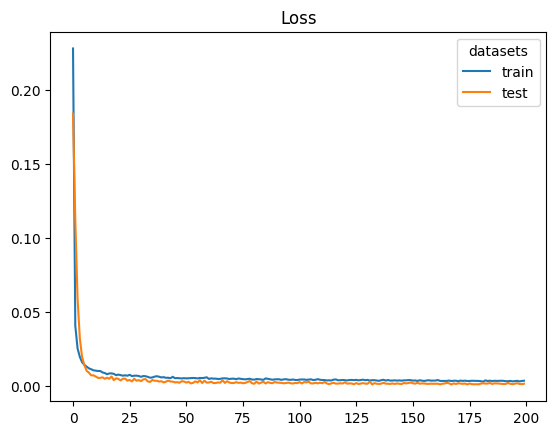

In [10]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

Epoch 1/200
42/42 - 5s - 120ms/step - loss: 0.2390 - val_loss: 0.0999
Epoch 2/200
42/42 - 0s - 5ms/step - loss: 0.0305 - val_loss: 0.0713
Epoch 3/200
42/42 - 0s - 11ms/step - loss: 0.0192 - val_loss: 0.0507
Epoch 4/200
42/42 - 1s - 16ms/step - loss: 0.0169 - val_loss: 0.0324
Epoch 5/200
42/42 - 1s - 14ms/step - loss: 0.0133 - val_loss: 0.0193
Epoch 6/200
42/42 - 0s - 10ms/step - loss: 0.0122 - val_loss: 0.0148
Epoch 7/200
42/42 - 0s - 12ms/step - loss: 0.0122 - val_loss: 0.0129
Epoch 8/200
42/42 - 0s - 6ms/step - loss: 0.0107 - val_loss: 0.0093
Epoch 9/200
42/42 - 0s - 7ms/step - loss: 0.0106 - val_loss: 0.0074
Epoch 10/200
42/42 - 0s - 7ms/step - loss: 0.0090 - val_loss: 0.0072
Epoch 11/200
42/42 - 0s - 6ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 12/200
42/42 - 0s - 6ms/step - loss: 0.0088 - val_loss: 0.0051
Epoch 13/200
42/42 - 0s - 6ms/step - loss: 0.0090 - val_loss: 0.0042
Epoch 14/200
42/42 - 0s - 6ms/step - loss: 0.0083 - val_loss: 0.0044
Epoch 15/200
42/42 - 0s - 8ms/step -

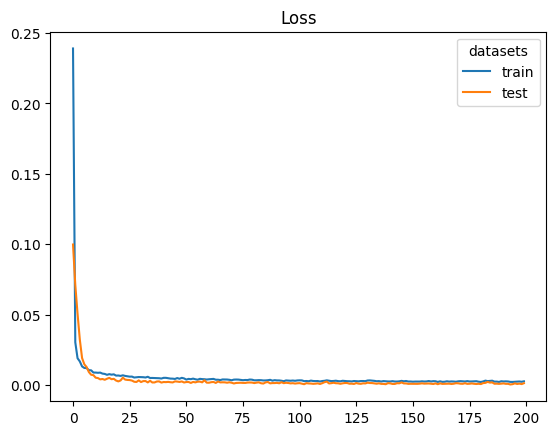

In [15]:
#Bottleneck=50
# define decoder, level 1
d = Dense(50)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

print("\n")
print("\n")

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

Epoch 1/200
42/42 - 5s - 122ms/step - loss: 0.2433 - val_loss: 0.1137
Epoch 2/200
42/42 - 0s - 5ms/step - loss: 0.0340 - val_loss: 0.0980
Epoch 3/200
42/42 - 0s - 6ms/step - loss: 0.0220 - val_loss: 0.0777
Epoch 4/200
42/42 - 0s - 6ms/step - loss: 0.0175 - val_loss: 0.0552
Epoch 5/200
42/42 - 0s - 6ms/step - loss: 0.0149 - val_loss: 0.0431
Epoch 6/200
42/42 - 0s - 7ms/step - loss: 0.0143 - val_loss: 0.0283
Epoch 7/200
42/42 - 0s - 9ms/step - loss: 0.0129 - val_loss: 0.0218
Epoch 8/200
42/42 - 0s - 10ms/step - loss: 0.0111 - val_loss: 0.0137
Epoch 9/200
42/42 - 0s - 10ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 10/200
42/42 - 0s - 9ms/step - loss: 0.0104 - val_loss: 0.0078
Epoch 11/200
42/42 - 0s - 9ms/step - loss: 0.0095 - val_loss: 0.0062
Epoch 12/200
42/42 - 0s - 11ms/step - loss: 0.0082 - val_loss: 0.0051
Epoch 13/200
42/42 - 1s - 13ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 14/200
42/42 - 1s - 14ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 15/200
42/42 - 0s - 7ms/step -

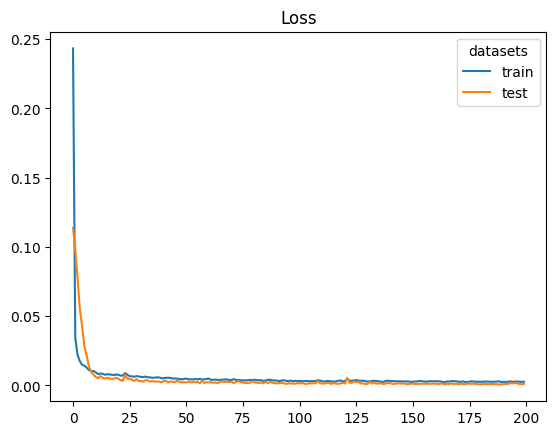

In [16]:
#Bottleneck=25
# define decoder, level 1
d = Dense(25)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))


print("\n")
print("\n")

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

Παρατηρούμε ότι όταν ο αριθμός εισόδου στο bottleneck μειώνεται, ταυτόχρονα μειώνεται κατά πολύ μικρή ποσότητα η απώλεια πληροφορίας στο validation test στα αντίστοιχα epochs (επαναλήψεις). Επίσης, όσο αυξάνονται τα epochs τόσο μειώνεται και η απώλεια πληροφορίας.
Παρ΄όλα αυτά,η μεγάλη εικόνα είναι ότι η επιλογή για το μέγεθος του Bottleneck δεν επηρεάζει την εκπαίδευση του Autoencoder για τις δεδομένες τιμές των παραμέτρων (όπως το πλήθος εποχών ή ο ρυθμός εκμάθησης)

**Ερώτηση 2**: Δοκιμάστε να τρέξετε το μοντέλο με Bottleneck: α) 50 και β) 25. Τι παρατηρείτε ως προς τα αποτελέσματα του μοντέλου;
**Ερώτηση 3**: δοκιμάστε να βάλετε τρία επίπεδα (τα δύο υφιστάμενα και ένα ακόμα με bottleneck 50). Τι διαφορές παρατηρείτε;

Epoch 1/200
42/42 - 6s - 150ms/step - loss: 0.2221 - val_loss: 0.1677
Epoch 2/200
42/42 - 0s - 7ms/step - loss: 0.0329 - val_loss: 0.0914
Epoch 3/200
42/42 - 0s - 7ms/step - loss: 0.0243 - val_loss: 0.0584
Epoch 4/200
42/42 - 0s - 7ms/step - loss: 0.0190 - val_loss: 0.0356
Epoch 5/200
42/42 - 0s - 7ms/step - loss: 0.0159 - val_loss: 0.0203
Epoch 6/200
42/42 - 0s - 8ms/step - loss: 0.0160 - val_loss: 0.0151
Epoch 7/200
42/42 - 0s - 7ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 8/200
42/42 - 0s - 7ms/step - loss: 0.0121 - val_loss: 0.0091
Epoch 9/200
42/42 - 1s - 15ms/step - loss: 0.0119 - val_loss: 0.0088
Epoch 10/200
42/42 - 0s - 8ms/step - loss: 0.0116 - val_loss: 0.0080
Epoch 11/200
42/42 - 1s - 15ms/step - loss: 0.0110 - val_loss: 0.0060
Epoch 12/200
42/42 - 1s - 15ms/step - loss: 0.0094 - val_loss: 0.0061
Epoch 13/200
42/42 - 1s - 13ms/step - loss: 0.0090 - val_loss: 0.0055
Epoch 14/200
42/42 - 0s - 8ms/step - loss: 0.0091 - val_loss: 0.0065
Epoch 15/200
42/42 - 1s - 15ms/step -

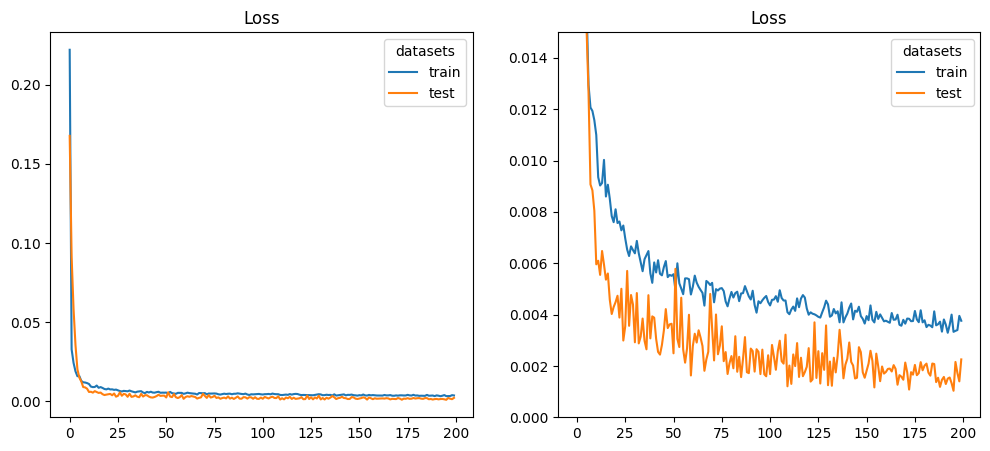

In [21]:
# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 3
e = Dense(int(n_inputs/2))(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
bottleneck = Dense(50)(e)

# define decoder, level 1
d = Dense(int(n_inputs/2))(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# define level 2
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 3
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

model.compile(optimizer='adam', loss='mse')

new_history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,5))

ax1.plot(new_history.history['loss'], label='train')
ax1.plot(new_history.history['val_loss'], label='test')
ax1.legend(title = "datasets")
ax1.set_title('Loss')

ax2.plot(new_history.history['loss'], label='train')
ax2.plot(new_history.history['val_loss'], label='test')
ax2.legend(title = "datasets")
ax2.set_ylim([0,0.015])
ax2.set_title('Loss')

pyplot.show()

Τοποθετώντας ένα επιπλέον επίπεδο παρατηρούμε ότι η απώλεια πληροφορίας είναι ακόμη πιο χαμηλή. Αυτό σημαίνει ότι μοντέλο μας γίνεται ακόμη πιο αποδοτικό.Βλέπουμε ότι δεν υπάρχουν μεγάλες διαφορές σε ό,τι έχει σχέση με την εκπαίδευση του μοντέλου.Το γεγονός αυτό φαίνεται από την πιο «απότομη» ταλαντωτική συμπεριφορά που εμφανίζει η συγκεκριμένη καμπύλη, καθώς και το ελαφρώς αυξημένο πλάτος των συγκεκριμένων ταλαντώσεων - πάντα σε σχέση με την κλίμακα που απεικονίζεται στο δεύτερο γράφημα.